In [1]:
import os
import h5py
import numpy
import matplotlib.pyplot as plt
import cv2
import numpy as np
from datetime import datetime
import pandas as pd
import time
from scipy.signal import savgol_filter
import scipy.signal as signal

In [207]:
def timestamp_to_numpy(timestamps):
    datetimes = [datetime.fromtimestamp(i) for i in timestamps]
    datetime_array = np.array(datetimes, dtype=np.datetime64)
    return(datetime_array)

def zscore(array):
    mean = array.mean()
    std = np.std(array)
    return((array-mean)/std)

def ms_from_start(datetimes):
    return(((datetimes-datetimes[0])/1000).astype(np.float64))

def get_mean_brightness(h5file, inds):
    lefts, rights = [], []
    for ind in inds:
        left = cv2.imdecode(h5file['left'][ind],0)
        right =  cv2.imdecode(h5file['right'][ind],0)
        lefts.append(left.mean())
        rights.append(right.mean())
    return(np.vstack((lefts, rights)).mean(axis=0))

def smooth(array, window_size=5):
    assert(window_size%2==1)
    filt = np.ones(window_size)/window_size
    # print(filt.sum())
    assert(abs(filt.sum()-1)<1e-6)
    
    return(np.convolve(array,filt, mode='same'))

def calculate_hist(array,binedges):
    binedges[0] = -np.inf
    binedges[-1] = np.inf
    histogram, bin_edges = np.histogram(array,binedges)
    bincenters = [(bin_edges[i]+bin_edges[i+1])/2 for i in range(len(bin_edges)-1)]
    return(histogram,bincenters)

def align_cameras_on_timestamps(filelist,master='right_post', WINDOW_SIZE=500,
                               use_window=True):
    # WINDOW_SIZE=500
    max_distance = 6 # ms
    
    frames = {}
    timestamps = {}
    sestimes = {}
    # filelist.sort()
    for key, file in filelist.items():
        if not file.endswith('t.h5'):
            continue
        with h5py.File(file, 'r') as f:
            framecounts = f['framecount'][:]
            timestamp = timestamp_to_numpy(f['timestamp'][:])
            sestime = f['sestime'][:]
        # key = os.path.basename(file)[:-3]
        frames[key] = framecounts
        timestamps[key] = timestamp
        sestimes[key]  = sestime
    N = min(len(frames[master]), len(timestamps[master]))
    camera_LUT = np.array((N,len(frames)), dtype=np.uint64)
    slaves = [i for i in list(frames.keys()) if i!=master]
    camera_LUT = np.zeros((N,len(frames)), dtype=np.float64)
    
    for i in range(0,N):
        camera_LUT[i,0] = i
        t = timestamps[master][i]
        min_search = max(0,i-WINDOW_SIZE)
        
        for j, slave in enumerate(slaves):
            max_search = min(len(frames[slave]),i+WINDOW_SIZE)
            # happens when there are large differences in numbers of images between two files
            # this likely means the master has way more images than the slave
            if max_search==min_search or min_search>max_search:
                camera_LUT[i,j+1]=np.nan
                continue
            if use_window:
                snippet = np.abs((timestamps[slave][min_search:max_search]-t).astype(np.float32)/1000)
                
            else:
                snippet = np.abs((timestamps[slave]-t).astype(np.float32)/1000)
            mint, argmin = snippet.min(), np.argmin(snippet)
            
            if mint < max_distance:
                val = argmin + min_search
            else:
                val = np.nan
            
            camera_LUT[i,j+1] = val
    
    # data = np.hstack((camera_LUT, timestamps[master]))
    df = pd.DataFrame(camera_LUT, columns=[master]+slaves)
    df['timestamps'] = timestamps[master]
    
    return(df)

def get_frames_by_index(camfiles, LUT, index, blank_frame=False, shape=(270,480)):
    lefts = []
    rights = []
    row = LUT.iloc[index,:]
    t = np.datetime64(row['timestamps'])
    for camname, file in camfiles.items():
        camind = row[camname]
        if not np.isnan(camind):
            camind = int(camind)
            with h5py.File(file, 'r') as f:
                left = cv2.imdecode(f['left'][camind],0)
                right = cv2.imdecode(f['right'][camind],0)
        else:
            if blank_frame:
                if len(lefts)> 0:
                    left = np.zeros_like(lefts[0])
                    right = np.zeros_like(rights[0])
                else:
                    left = np.zeros(shape, dtype=np.uint8)
                    right = np.zeros(shape, dtype=np.uint8)
            else:
                left, right = None, None
        lefts.append(left)
        rights.append(right)
            
    return(lefts, rights)

Use timestamps for alignment. Above experiments with light show that the cameras timestamps are only off by <100 ms throughout the ten minutes of imaging. 

* Make a big array, with N rows, and N-cams+1 columns
    * in the 0th row: `index of mastercam (so row number)`, `index of cam0 (NaN if DNE)`, `index of cam1`, `index of cam2`, `index of cam3`, `index of wavesurfer file corresponding to that frame`
* for each frame in the mastercam (always the biggest N)
    * find nearest frame in time in other 3 cams, within a given window (e.g. less than 1000 frames)
        * if the nearest entry is < 6ms or whatever, match, and delete that entry so it can't be matched
        * else, put a `NaN`


In [3]:
cams = ['left_ant', 'left_post', 'right_ant','right_post']

# Check image quality. Show example images. Make example movies

In [245]:
datedir = r'/media/jim/FASTER/realsense/190327'
indatedir = os.listdir(datedir)
indatedir.sort(key=str.casefold)

datafile = indatedir[18]
print(datafile)
datadir = os.path.join(datedir, datafile)

JB043_witheye_191927_171951


In [233]:
_ = [print(i,file) for i,file in enumerate(indatedir)]

0 examples
1 eye.avi
2 eye_compressed.avi
3 eye_JB040.avi
4 eye_JB040_compressed.avi
5 eye_JB041.avi
6 eye_JB041_compressed.avi
7 eye_JB043.avi
8 eye_JB043_compressed.avi
9 JB040_2019-03-27_0003.h5
10 JB040_witheye_193827_163836
11 JB041_2019-03-27_0001.h5
12 JB041_witheye_195627_165605
13 JB042_2019-03-27_0001.h5
14 JB042_2019-03-27_0002.h5
15 JB042_witheye_190727_160748
16 JB042_witheye_191427_161456
17 JB043_2019-03-27_0001.h5
18 JB043_witheye_191927_171951


In [246]:
camfiles = os.listdir(datadir)
camfiles.sort()
camfiles = {os.path.basename(i)[:-3]: os.path.join(datadir,i) for i in camfiles if i.endswith('t.h5')}

LUT = align_cameras_on_timestamps(camfiles)

In [249]:
max_distance = 6 # ms
    
frames = {}
timestamps = {}
sestimes = {}
# filelist.sort()
for key, file in camfiles.items():
    if not file.endswith('t.h5'):
        continue
    with h5py.File(file, 'r') as f:
        framecounts = f['framecount'][:]
        timestamp = timestamp_to_numpy(f['timestamp'][:])
        sestime = f['sestime'][:]
    # key = os.path.basename(file)[:-3]
    frames[key] = framecounts
    timestamps[key] = timestamp
    sestimes[key]  = sestime

In [251]:
timestamps['right_ant']

array(['2019-03-27T17:19:57.884211', '2019-03-27T17:19:57.917667',
       '2019-03-27T17:19:57.934412', ..., '2019-03-27T17:34:57.702064',
       '2019-03-27T17:34:57.718409', '2019-03-27T17:34:57.735013'],
      dtype='datetime64[us]')

In [255]:
timestamps['left_post'][100:200]

array(['2019-03-27T17:19:59.035371', '2019-03-27T17:19:59.052030',
       '2019-03-27T17:19:59.068547', '2019-03-27T17:19:59.085239',
       '2019-03-27T17:19:59.103347', '2019-03-27T17:19:59.135396',
       '2019-03-27T17:19:59.152141', '2019-03-27T17:19:59.168654',
       '2019-03-27T17:19:59.185598', '2019-03-27T17:19:59.202070',
       '2019-03-27T17:19:59.218741', '2019-03-27T17:19:59.235502',
       '2019-03-27T17:19:59.252339', '2019-03-27T17:19:59.268718',
       '2019-03-27T17:19:59.285505', '2019-03-27T17:19:59.302127',
       '2019-03-27T17:19:59.318834', '2019-03-27T17:19:59.336390',
       '2019-03-27T17:19:59.352243', '2019-03-27T17:19:59.385756',
       '2019-03-27T17:19:59.402683', '2019-03-27T17:19:59.418862',
       '2019-03-27T17:19:59.435633', '2019-03-27T17:19:59.452292',
       '2019-03-27T17:19:59.469555', '2019-03-27T17:19:59.486193',
       '2019-03-27T17:19:59.502386', '2019-03-27T17:19:59.519202',
       '2019-03-27T17:19:59.535974', '2019-03-27T17:19:59.5523

In [254]:
np.sum(np.isnan(LUT['left_post']))/len(LUT)

0.6554894206857189

In [258]:
np.where(np.isnan(LUT['left_post']))[0][500:1000]

array([3505, 3514, 3519, 3529, 3539, 3548, 3555, 3561, 3571, 3581, 3587,
       3588, 3595, 3600, 3607, 3624, 3633, 3642, 3649, 3667, 3682, 3688,
       3695, 3705, 3713, 3720, 3732, 3741, 3751, 3757, 3773, 3784, 3793,
       3801, 3807, 3814, 3821, 3834, 3838, 3850, 3861, 3885, 3897, 3907,
       3912, 3923, 3932, 3942, 3947, 3956, 3964, 3972, 3980, 3986, 3993,
       4003, 4011, 4018, 4026, 4031, 4038, 4046, 4052, 4060, 4071, 4078,
       4095, 4104, 4113, 4117, 4125, 4133, 4146, 4160, 4167, 4175, 4192,
       4200, 4209, 4219, 4230, 4238, 4246, 4264, 4270, 4278, 4286, 4295,
       4305, 4312, 4321, 4328, 4335, 4341, 4350, 4358, 4365, 4374, 4384,
       4402, 4409, 4416, 4423, 4431, 4440, 4448, 4458, 4468, 4478, 4483,
       4492, 4501, 4536, 4546, 4556, 4563, 4584, 4591, 4597, 4608, 4615,
       4623, 4630, 4637, 4657, 4664, 4671, 4682, 4693, 4701, 4713, 4721,
       4732, 4739, 4747, 4756, 4767, 4774, 4783, 4788, 4796, 4815, 4825,
       4833, 4844, 4848, 4855, 4865, 4876, 4891, 49

In [247]:
index = np.random.randint(low=0, high=len(LUT))
lefts, rights = get_frames_by_index(camfiles, LUT, index)

In [214]:
datadir

'/media/jim/FASTER/realsense/190327/JB041_witheye_195627_165605'

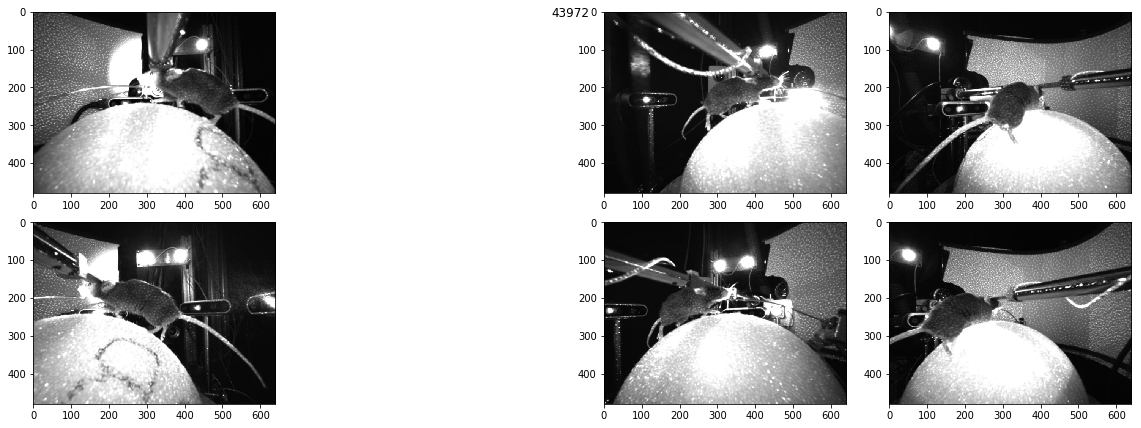

In [248]:
fig, ax = plt.subplots(2,4,figsize=(16,6))
for i in range(4):
    left = lefts[i]
    right = rights[i]
    if left is not None:
        ax[0,i].imshow(left, 'gray')
        ax[1,i].imshow(right,'gray')
    else:
        ax[0,i].remove()
        ax[1,i].remove()
    ax[0,i].grid(False)
    ax[1,i].grid(False)
fig.suptitle('%d'%index)
plt.tight_layout()
plt.show()
    

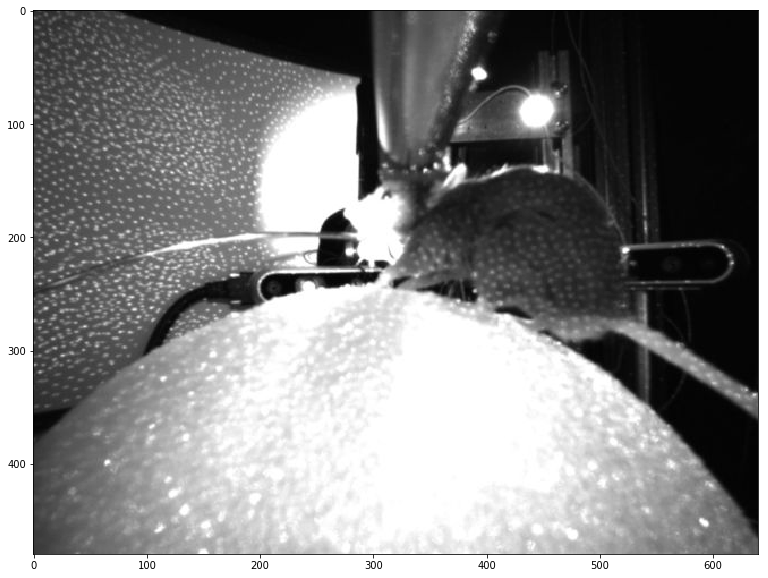

In [238]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
ax.imshow(lefts[0],'gray', interpolation='nearest')
ax.grid(False)
plt.show()

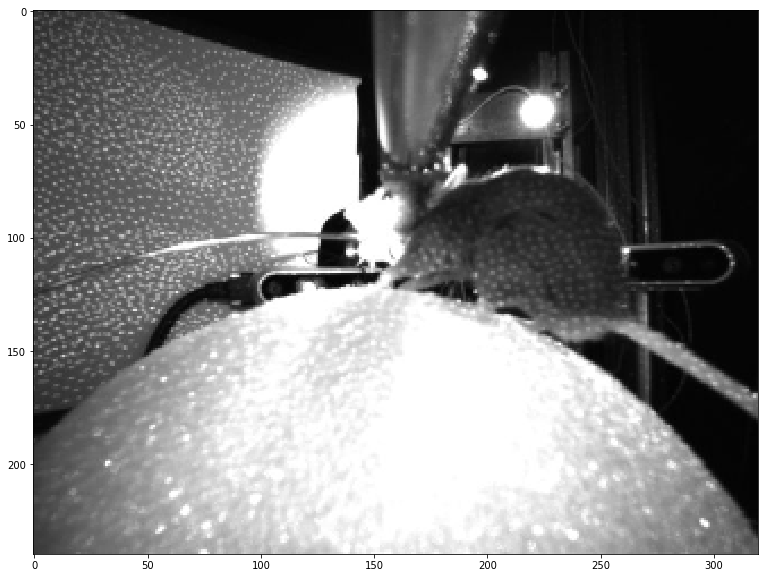

In [239]:
fig, ax = plt.subplots(1,1,figsize=(18,10))
H, W = lefts[0].shape
im = cv2.resize(lefts[0], (W//2,H//2), interpolation=cv2.INTER_NEAREST)
ax.imshow(im,'gray', interpolation='nearest')
ax.grid(False)
plt.show()

In [259]:
N=1800
index = np.random.randint(low=0, high=len(LUT)-N)
# index = 172014
# index = 1000
indices = range(index, index+N)

In [242]:
%pdb

Automatic pdb calling has been turned OFF


In [260]:
print(datadir)

/media/jim/FASTER/realsense/190327/JB043_witheye_191927_171951


In [261]:
preview = True
save = True
mouse = 'JB043'

lefts, _ = get_frames_by_index(camfiles, LUT, indices[0], blank_frame=True)

width = lefts[0].shape[1]
height = lefts[0].shape[0]
fps = 30

In [262]:
N_cams = 4
framesize = (width*4, height*2)

startind = indices[0]
endind = indices[-1]
if preview:
#     cv2.namedWindow('Realsense', cv2.WINDOW_AUTOSIZE)
#     cv2.namedWindow('Flea', cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow('Joined', cv2.WINDOW_AUTOSIZE)
    waittime = int(1000/fps)
if save:
    outdir = os.path.join(datadir, 'examples')
    if not os.path.isdir(outdir):
        os.makedirs(outdir)
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    filename = '%s_%07d_%07d.avi' %(mouse, startind, endind)
    writer = cv2.VideoWriter(os.path.join(outdir, filename),fourcc, fps, framesize)
try:
    for i in range(startind,endind):
        t0 = time.perf_counter()
        
        lefts, rights = get_frames_by_index(camfiles, LUT, i, blank_frame=True,
                                           shape=(height,width))
        top = np.hstack(lefts)
        bottom = np.hstack(rights)
        out = np.vstack((top,bottom))

        #         r = np.hstack((r_l, r_r))
        #         f = np.hstack((f_l, f_r))

        #         rheight, rwidth = r.shape
        #         fheight, fwidth = f.shape
        #         out_width = int(fwidth)
        #         out_height = int(fwidth/rwidth*rheight)
        #         out = np.vstack((cv2.resize(r,(out_width,out_height)),
        #                         f))
        out = cv2.cvtColor(out, cv2.COLOR_GRAY2RGB)
        text = '%s:%07d' %(mouse, i)
        cv2.putText(out, text, (50,out.shape[0]-50),
                   fontFace=cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,
                   color=(0,0,255),thickness=1,lineType=cv2.LINE_AA)
        if save:
            writer.write(out)

        if preview:
            # cv2.imshow('Realsense', r)
            # cv2.imshow('Flea',f)
            cv2.imshow('Joined', out)
            elapsed = int((time.perf_counter() - t0)*1000)

            key = cv2.waitKey(max([1,elapsed]))
            if key==27:
                print('User stopped')
                break
                # raise KeyboardInterrupt
except BaseException as e:
    print(e.message)
finally:
    if preview:
        cv2.destroyAllWindows()
    if save:
        writer.release()